In [1]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix


from nlp_classification.environment_reference import EnvironmentReference
from nlp_classification.fill_functions import FeatureSelector, Cleaner, Lemmatizer
from nlp_classification.fill_functions import get_cloud, get_corpus, add_stop_words, plot_confusion_matrix


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

nltk.download('stopwords')

font = {'size' : 15}
plt.rc('font', **font)

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

[nltk_data] Downloading package stopwords to /home/mahh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Необходимо классифицировать сообщения на предмет того, из какого чата они были взяты.
Датасет представляет собой сообщения участников двух публичных чатов:
- Чат по Python (label=0)
- Чат по Data Science (label=1)


### Задачи:
1. Сделать предобработку текстов
2. Предложить модель классификации, метрики.
3. Объяснить их выбор (достоинства/недостатки).
4. Сделать выводы по работе модели(ей) (достоинства/недостатки),
а также проблемы, с которыми вы или ваша модель столкнулась.

### Загрузка данных

In [2]:
load_dotenv()

data = pd.read_csv(os.getenv(EnvironmentReference.RESEARCH_DATA_PATH))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12404 entries, 0 to 12403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12404 non-null  object
 1   label   12404 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 193.9+ KB


Посмотрим на баланс классов

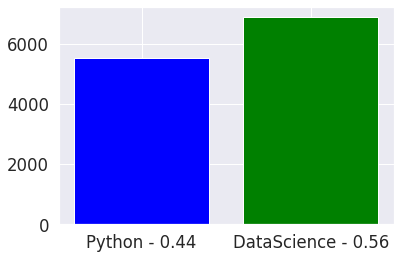

In [3]:
group_data = data.groupby('label').describe()
python_norm = round(data['label'].value_counts(normalize=True)[0],2)
ds_norm = round(data['label'].value_counts(normalize=True)[1],2)

plt.bar(f'Python - {python_norm}',group_data['text']['count'][0],
        label = 'Python', color = 'blue')
plt.bar(f'DataScience - {ds_norm}',group_data['text']['count'][1],
        label = 'DataScience', color = 'green')
plt.show()

Выборка имеет хороший баланс лейблов. На самом деле в подобных задачах(векторизации) плохая
балансировка не является чем-то неразрешимым.

Создадим облако слов, чтобы визуально подтвердить необходимость очистки текста

/home/mahh/nlp_classification/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


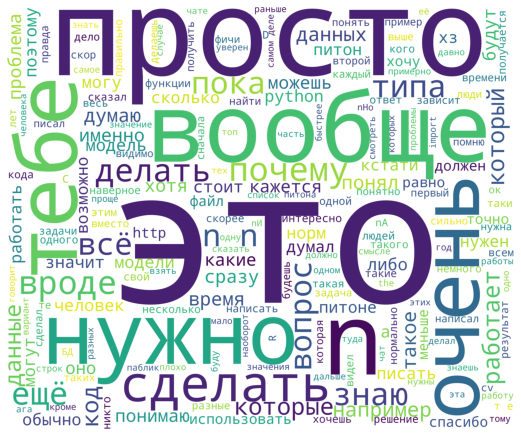

In [4]:
corpus = get_corpus(data['text'].values)
procWordCloud = get_cloud(corpus)


fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

# Это вообще просто :D

Явно нужна очистка

### Преобработка текста

Для предобработки текста были реализованы классы Cleaner(очистка текста) и Lemmatizer(лемматизация).
Из библиотеки nltk были подгружены стоп-слова для дальнейшего удаления их из текста,
они не несут смысловой нагрузки и лишь вносят шум + нагружают модель.

#### Подгрузим стандартный ру-словарь стоп-слов из библиотеки nltk
Важно!! Забегая вперед, скажу что этого словаря будет недостаточно, т.к. он фактически учебный и содержит
в себе мало слов-паразитов. Так же очень важно подметить, что сообщения в данных из чатов программистов, значит существует
некий сленг, который так-же будет вносить шум при работе модели.

Для устранения этой проблемы обогатим уже существующий словарь топ k словами, которыми насыщщен документ.

In [5]:
k = 20
data_stopwords = add_stop_words(data, k)

#### Создадим пайплайны для классификаторов:
1. MultinomialNB
2. SGDClassifier
3. LogisticRegression
4. RandomForestClassifier
5. CatBoostClassifier
6. KNeighborsClassifier

P.S. CatBoostClassifier очень долго обучается, к тому-же без тонких настроек он дает самую плохую метрику из всех
представленных классификаторов. Мой ноутбук будет очень долго подбирать параметры по Grid, вынужден отказаться
в силу быстродействия выполнения. При этом я не отрицаю что возможно при должных настройках он покажет высокие результаты

In [6]:
classifier_1 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                   strip_accents='unicode',
                                                   analyzer='word', # аналитика по словам
                                                   token_pattern=r'\w{1,}', # выдергиваем разделители
                                                # длина ngram(ngram - смотрим на последовательности слов длиной 1 с шагом 1)
                                                   ngram_range=(1, 1),
                                                   max_features=10000)),
                         ('clf', MultinomialNB())])

classifier_2 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3))])


classifier_3 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', LogisticRegression(penalty='l2',C=2))])

classifier_4 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', RandomForestClassifier())])

classifier_6 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', KNeighborsClassifier(n_neighbors=100))])


Разобьем данные на train/test с использованием стратификации

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', 1),
                                                    data['label'],
                                                    random_state=42,
                                                    stratify=data['label'])

Проверю баланс в обучащей и тестовой выборках

In [8]:
print(f'Train:\n{y_train.value_counts(normalize=True)}')
print(f'Test:\n{y_test.value_counts(normalize=True)}')

Train:
1    0.55509
0    0.44491
Name: label, dtype: float64
Test:
1    0.554982
0    0.445018
Name: label, dtype: float64


#### Запустим кросс-валидацию на 4-х фолдах
В кач-ве метрики проверки качеcтва возьму площадь под кривой ROC

In [9]:
%%time

cv_scores_1 = cross_val_score(classifier_1, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_1 = np.mean(cv_scores_1)
print('MultinomialNB CV score is {}'.format(cv_score_1))

cv_scores_2 = cross_val_score(classifier_2, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_2 = np.mean(cv_scores_2)
print('SGDClassifier CV score is {}'.format(cv_score_2))

cv_scores_3 = cross_val_score(classifier_3, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_3 = np.mean(cv_scores_3)
print('LogisticRegression CV score is {}'.format(cv_score_3))

cv_scores_4 = cross_val_score(classifier_4, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_4 = np.mean(cv_scores_4)
print('RandomForestClassifier CV score is {}'.format(cv_score_4))

cv_scores_6 = cross_val_score(classifier_6, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_6 = np.mean(cv_scores_6)
print('KNeighborsClassifier CV score is {}'.format(cv_score_6))

MultinomialNB CV score is 0.874406657550815
SGDClassifier CV score is 0.8551731692619008
LogisticRegression CV score is 0.8559887414462531
RandomForestClassifier CV score is 0.8078098660698811
KNeighborsClassifier CV score is 0.82379811722046
CPU times: user 2min 41s, sys: 3.54 s, total: 2min 45s
Wall time: 2min 42s


Удивительно, но без тонких настроек MultinomialNB дает самый лучший результат на кросс-валидации.
Попробую подобрать порог для каждой модели и посмотрим на метрики.

Для этого обучу все классификаторы и получу предикты

In [10]:
%%time

classifier_1.fit(X_train, y_train)
y_score_1 = classifier_1.predict_proba(X_test)[:, 1]

classifier_2.fit(X_train, y_train)
y_score_2 = classifier_2.predict_proba(X_test)[:, 1]

classifier_3.fit(X_train, y_train)
y_score_3 = classifier_3.predict_proba(X_test)[:, 1]

classifier_4.fit(X_train, y_train)
y_score_4 = classifier_4.predict_proba(X_test)[:, 1]

classifier_6.fit(X_train, y_train)
y_score_6 = classifier_6.predict_proba(X_test)[:, 1]

CPU times: user 51.6 s, sys: 1.18 s, total: 52.8 s
Wall time: 52 s


In [11]:
# Найдем точность, полноту и порог для каждого классификатора
precision_1, recall_1, threshold_1 = precision_recall_curve(y_test.values, y_score_1)
precision_2, recall_2, threshold_2 = precision_recall_curve(y_test.values, y_score_2)
precision_3, recall_3, threshold_3 = precision_recall_curve(y_test.values, y_score_3)
precision_4, recall_4, threshold_4 = precision_recall_curve(y_test.values, y_score_4)
precision_6, recall_6, threshold_6 = precision_recall_curve(y_test.values, y_score_6)

# Найдем F-меру для каждого классификатора
f_score_1 = (2*precision_1 * recall_1)/(precision_1 + recall_1)
f_score_2 = (2*precision_2 * recall_2)/(precision_2 + recall_2)
f_score_3 = (2*precision_3 * recall_3)/(precision_3 + recall_3)
f_score_4 = (2*precision_4 * recall_4)/(precision_4 + recall_4)
f_score_6 = (2*precision_6 * recall_6)/(precision_6 + recall_6)

# Найдем индекс максимального значения F-меры. При этом эти же индексы будут принадлежать оптимальным значениям
# точности, полноты и порога
ix1 = np.argmax(f_score_1)
ix2 = np.argmax(f_score_2)
ix3 = np.argmax(f_score_3)
ix4 = np.argmax(f_score_4)
ix6 = np.argmax(f_score_6)

roc_score_1 = roc_auc_score(y_test, y_score_1)
roc_score_2 = roc_auc_score(y_test, y_score_2)
roc_score_3 = roc_auc_score(y_test, y_score_3)
roc_score_4 = roc_auc_score(y_test, y_score_4)
roc_score_6 = roc_auc_score(y_test, y_score_6)

In [12]:
pd.DataFrame(data = [[f_score_1[ix1],roc_score_1,precision_1[ix1],recall_1[ix1],threshold_1[ix1]],
                    [f_score_2[ix2],roc_score_2, precision_2[ix2],recall_2[ix2],threshold_2[ix2]],
                    [f_score_3[ix3],roc_score_3,precision_3[ix3],recall_3[ix3],threshold_3[ix3]],
                    [f_score_4[ix4],roc_score_4,precision_4[ix4],recall_4[ix4],threshold_4[ix4]],
                    [f_score_6[ix6],roc_score_6,precision_6[ix6],recall_6[ix6],threshold_6[ix6]]],
            index = ['MultinomialNB','SGDClassifier','LogReg','RFC','KNeighborsClassifier'],
            columns = ['F_score','ROC-AUC','Precision','Recall','Threshold']).sort_values(by='ROC-AUC',
                                                                                          ascending=False)

,F_score,ROC-AUC,Precision,Recall,Threshold
MultinomialNB,0.838501,0.886276,0.782193,0.903544,0.472878
LogReg,0.821579,0.868129,0.750842,0.907031,0.432015
SGDClassifier,0.820433,0.864877,0.743856,0.914585,0.459793
KNeighborsClassifier,0.802551,0.838066,0.767639,0.840790,0.530000
RFC,0.795080,0.813382,0.723333,0.882626,0.420000


По соотноению сложности и эффективности MultinomialNB выигрывает, на втором месте идет LogLoss.

Зная как он работает, могу предположить, что для решения конкретной задачи связь между словами(с которой алгоритм работает плохо)
не так важна. Возможно так оно и есть - сленговые слова тематики программирования встречаются в обоих классах,
но в чатике DS встречаются слова с сильным уклоном в математику/сленговые выражения DS,
что явно свидетельствует о принадлежности к данному классу.

Странно, думал это будет SGD, но имеем что имеем.
Попробую улучшить алгоритмы путем подбора параметров по сетке.


In [13]:
# %%time
#
# parameters_mnb = {
#     'clf__alpha':[0, 0.1, 0.3, 0.5, 0.7, 1.2],
#     'clf__fit_prior':[True, False],
#     'tfidf__ngram_range':[(1,1), (2,3), (3,4)],
#     'tfidf__max_features':[100,1000,10000]
# }
#
# model_mnd = GridSearchCV(classifier_1, parameters_mnb, cv=4, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)
#
# print(f'Best score and parameter combination:\n{model_mnd.best_score_, model_mnd.best_params_}')


In [14]:
# Очень долго...2 часа ждал
# %%time
#
# parameters_loss = {
#     'clf__penalty':['l2'],
#     'clf__C':[0.1,1,2,5],
#     'clf__class_weight':['balanced',None],
#     'clf__max_iter':[50,100,1000],
#     'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
#     'tfidf__ngram_range':[(1,1), (2,3), (3,4)],
#     'tfidf__max_features':[100,1000,10000]
# }
#
# model_loss = GridSearchCV(classifier_3, parameters_loss, cv=4, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)
#
# print(f'Best score and parameter combination:\n{model_loss.best_score_, model_loss.best_params_}')

#### Обучим модель с найденными параметрами и посмотрим на ROC + матрицу ошибок

In [51]:
model = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text',
                                              words_to_add=data_stopwords)),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                   strip_accents='unicode',
                                                   analyzer='word', # аналитика по словам
                                                   token_pattern=r'\w{1,}', # выдергиваем разделители
                                                # длина ngram(ngram - смотрим на последовательности слов длиной 1 с шагом 1)
                                                   ngram_range=(1, 1),
                                                   max_features=10000)),
                         ('clf', MultinomialNB(alpha=0.5,fit_prior=True))])

model.fit(X_train, y_train)
model_predict = model.predict_proba(X_test)[:, 1]
model_predict

array([0.23335294, 0.35916604, 0.91170022, ..., 0.72340484, 0.72982838,
       0.11380684])

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test.values, model_predict)
fscore = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(roc_auc_score(y_test.values,model_predict))

Best Threshold=0.442539, F-Score=0.839, Precision=0.780, Recall=0.905
0.8874969473427146


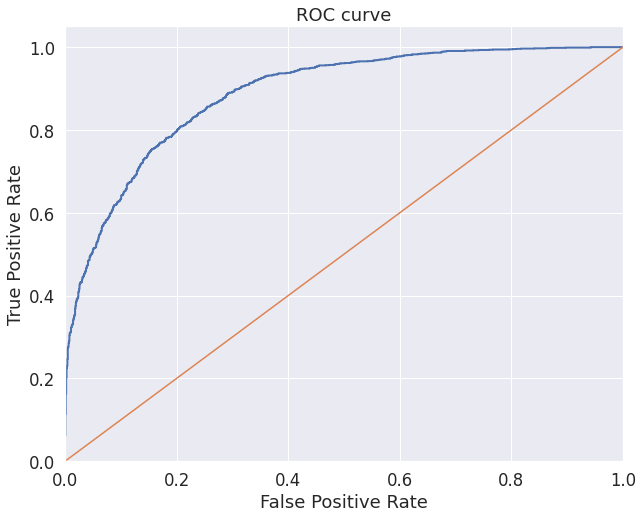

In [56]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, model_predict, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Normalized confusion matrix
[[0.6826087  0.3173913 ]
 [0.09471238 0.90528762]]


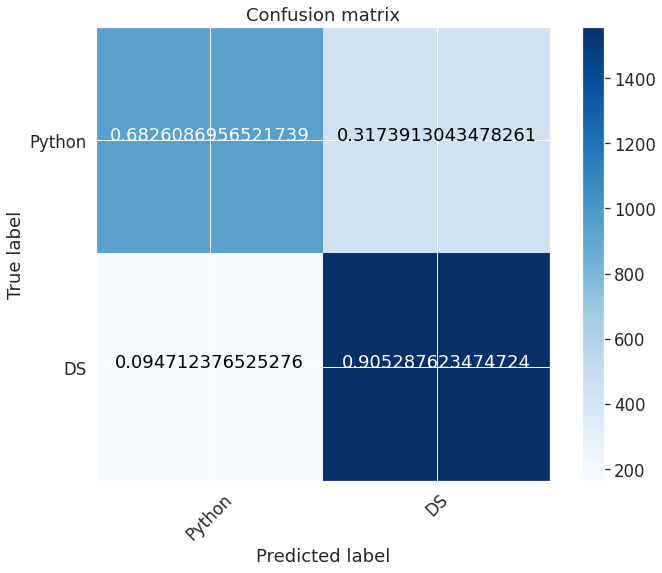

(0.905287623474724, 0.3173913043478261, 0.6826086956521739)

In [63]:

cnf_matrix = confusion_matrix(y_test, model_predict>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Python','DS'], normalize=True,
                      title='Confusion matrix')
plt.show()


TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)

TPR, FPR, TNR

Как видно на матрице, модель довольно много ошибается в плане присвоения класса DS сообщениям из чата Python.
Темы довольно смежные, для достижения лучших результатов можно попробовать использовать более сложные алгоритмы.
Так-же можно составить более тщательный морфологический разбор(словари) сленговых выражений.


Плюсы модели:
- простота алгоритма
- скорость обучения
- может автоматически распознавать 90% сообщений по тематике DS

Минусы модели:
- около 31% сообщений по Python получают метку DS, что не есть хорошо